In [1]:
import os
import sys
cwd = os.path.abspath('')
cwd_parent, _ = os.path.split(cwd)
sys.path.append(cwd_parent)

from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import clip
import torch
from random import randint

from NegCLIP.COCO_Dataset import COCODataset
from torch.utils.data import DataLoader
from tqdm import tqdm

## CLIP

In [3]:
model, preprocess = clip.load("ViT-B/32", device="cpu")

In [39]:
SET_TYPE = "val"
BATCH_SIZE = 20
COCO_ORDER_PATH = "../ARO_benchmark/COCO_Order/captions_shuffled_captions.json"


coco_dts = COCODataset(root=f'../COCO/{SET_TYPE}2014/', pairwise_sim_path=f"../COCO/pairwise_sim/{SET_TYPE}.csv",
                           annFile=f'../COCO/annotations/captions_negcaptions_{SET_TYPE}2014.json',
                           transform=preprocess, target_transform=clip.tokenize)
dts_size = len(coco_dts)
coco_loader = DataLoader(coco_dts, batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!


In [48]:
text_embedding = torch.Tensor()
y = []
for i, data in tqdm(enumerate(coco_loader), leave=False, total=len(coco_loader)):
    images, captions = data
    b, _, _, _, _ = images.shape
    captions_pos = captions[:, 0:2, :].flatten(0, 1)
    captions_neg = captions[:, 2:, :].flatten(0, 1)
    images = images.flatten(0, 1)  # BSCHW -> (B*S)CHW
  
    encoded_text = model.encode_text(torch.cat((captions_pos, captions_neg))) 
    encoded_text = encoded_text/encoded_text.norm(dim=1, keepdim=True)
    encoded_images = model.encode_image(images)
    encoded_images = encoded_images/encoded_images.norm(dim=1, keepdim=True)

    sim_text = model.logit_scale * encoded_text @ encoded_text.t()
    sim_image = model.logit_scale * encoded_images @ encoded_images.t()

    logits = model.logit_scale * encoded_images @ encoded_text.t()
    text_embedding = torch.cat((text_embedding, encoded_text))
    y = y+[1]*2*b +[0]*2*b

    if i==0:
        break
print(text_embedding.shape)
y = np.array(y)
print(y.shape)

torch.Size([80, 512])
(80,)


In [44]:
x = TSNE(n_components=2, perplexity=3).fit_transform(text_embedding.detach().numpy())

/home/teo/anaconda3/envs/clip_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/teo/anaconda3/envs/clip_env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


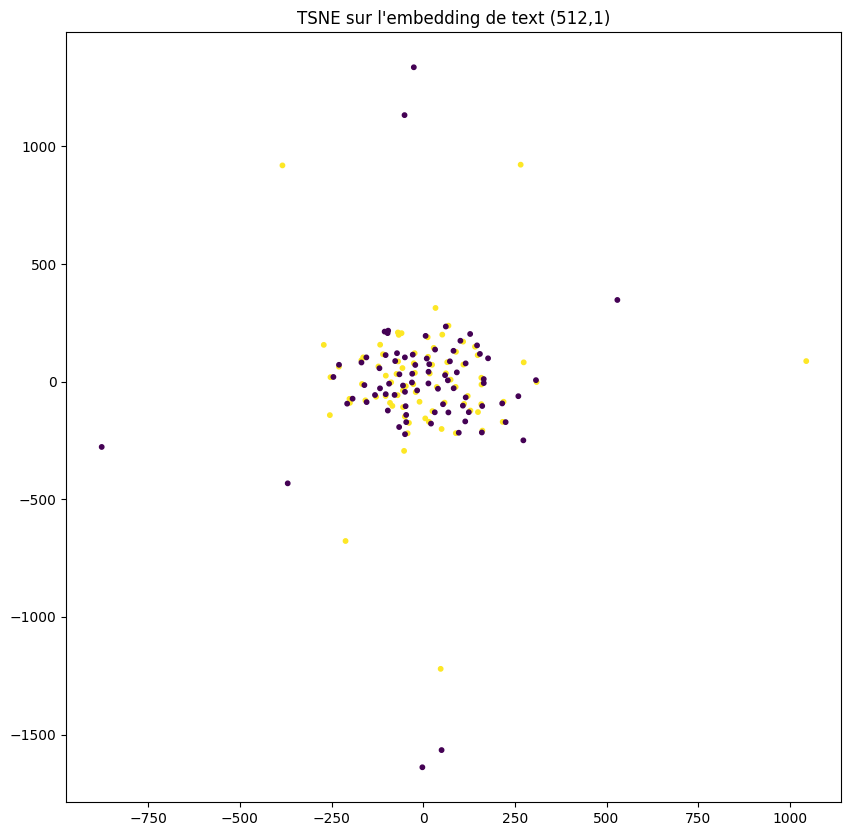

In [45]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_title("TSNE sur l'embedding de text (512,1)")
line = ax.scatter(x[:,0],x[:,1], c=y, s=10)          
plt.show()

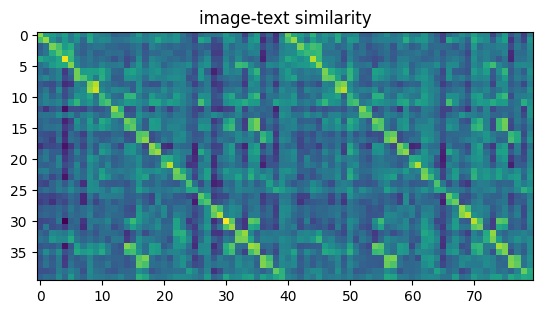

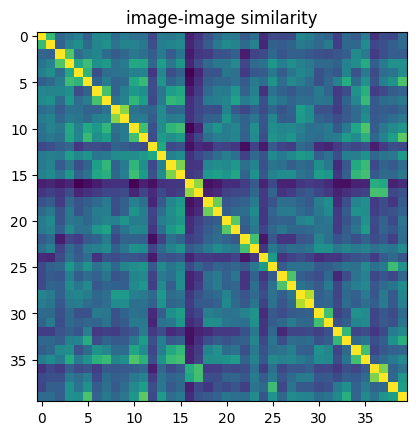

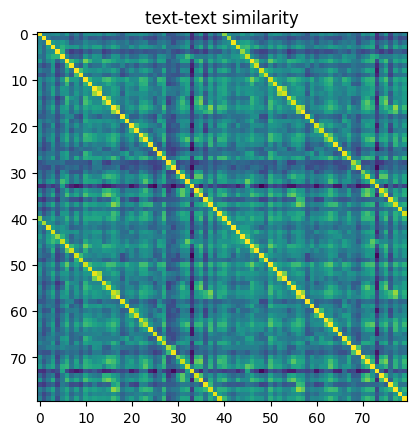

: 

In [55]:
plt.imshow(logits)
plt.title("image-text similarity")
plt.show()
plt.imshow(sim_image.detach().numpy())
plt.title("image-image similarity")
plt.show()
plt.imshow(sim_text.detach().numpy())
plt.title("text-text similarity")
plt.show()

## NegCLIP Text FT

In [2]:
weight_path = "weights/neclip-ftxt-lr5e-06-epoch9.pth"
clip_model, preprocess = clip.load("ViT-B/32", device="cpu")
clip_model.load_state_dict(torch.load(weight_path, map_location="cpu"))
model = clip_model
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [7]:
SET_TYPE = "val"
BATCH_SIZE = 20
COCO_ORDER_PATH = "../ARO_benchmark/COCO_Order/captions_shuffled_captions.json"


coco_dts = COCODataset(root=f'../COCO/{SET_TYPE}2014/', pairwise_sim_path=f"../COCO/pairwise_sim/{SET_TYPE}.csv",
                           annFile=f'../COCO/annotations/captions_negcaptions_{SET_TYPE}2014.json',
                           transform=preprocess, target_transform=clip.tokenize)
dts_size = len(coco_dts)
coco_loader = DataLoader(coco_dts, batch_size=BATCH_SIZE)

loading annotations into memory...
Done (t=1.83s)
creating index...
index created!


In [ ]:
text_embedding = torch.Tensor()
y = []
for i, data in tqdm(enumerate(coco_loader), leave=False, total=len(coco_loader)):
    images, captions = data
    b, _, _, _, _ = images.shape
    captions_pos = captions[:, 0:2, :].flatten(0, 1)
    captions_neg = captions[:, 2:, :].flatten(0, 1)
    images = images.flatten(0, 1)  # BSCHW -> (B*S)CHW

    encoded_text = model.encode_text(torch.cat((captions_pos, captions_neg)))
    encoded_text = encoded_text/encoded_text.norm(dim=1, keepdim=True)
    encoded_images = model.encode_image(images)
    encoded_images = encoded_images/encoded_images.norm(dim=1, keepdim=True)

    sim_text = model.logit_scale * encoded_text @ encoded_text.t()
    sim_image = model.logit_scale * encoded_images @ encoded_images.t()

    logits = model.logit_scale * encoded_images @ encoded_text.t()
    text_embedding = torch.cat((text_embedding, encoded_text))
    y = y+[1]*2*b +[0]*2*b

    if i==0:
        break
print(text_embedding.shape)
y = np.array(y)
print(y.shape)

  0%|          | 0/2026 [00:00<?, ?it/s]

In [ ]:
plt.imshow(logits.detach().numpy())
plt.title("image-text similarity")
plt.show()
plt.imshow(sim_image.detach().numpy())
plt.title("image-image similarity")
plt.show()
plt.imshow(sim_text.detach().numpy())
plt.title("text-text similarity")
plt.show()